In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy as sc
from scipy import io
from IPython import display
import time

from sklearn.metrics import mean_squared_error
from sklearn.cross_decomposition import PLSRegression

from nonlinearities import *
from pls import *
from sklearn.decomposition import PCA


np.random.seed(42)

In [202]:
x_mean = np.array([0., 0.])
x_cov = np.array([[.25, .2],
                 [.2, .3]])
size=50
X = np.random.multivariate_normal(x_mean, x_cov, size)

In [203]:
y_mean = np.array([0., 0.])
y_cov = np.array([[.25, -0.2],
                 [-0.2, .3]])
Y = np.random.multivariate_normal(y_mean, y_cov, size)

In [204]:
x_pca = PCA(n_components=2)
x_pca.fit(X)
x_comps = x_pca.components_
x_comps

array([[ 0.69382207,  0.72014647],
       [ 0.72014647, -0.69382207]])

In [205]:
y_pca = PCA(n_components=2)
y_pca.fit(Y)
y_comps = y_pca.components_
y_comps

array([[-0.68422812,  0.72926805],
       [ 0.72926805,  0.68422812]])

In [206]:
pls = PLSNonLinear(n_components=2, x_kind='linear', y_kind='linear')

pls.fit(X, Y)

PLSNonLinear(learning_rate=1.0, max_iter=300, n_components=2, scale=True,
       tol=1e-06, x_kind='linear', y_kind='linear')

In [207]:
print(x_comps) 
print(y_comps)

[[ 0.69382207  0.72014647]
 [ 0.72014647 -0.69382207]]
[[-0.68422812  0.72926805]
 [ 0.72926805  0.68422812]]


In [208]:
x_angle = np.arccos(x_comps[0][0]) * 180 / np.pi
y_angle = np.arccos(y_comps[0][0]) * 180 / np.pi
print(x_angle, y_angle)

46.0665742799 133.1749331


In [209]:
W = pls.x_weights_.T
C = pls.y_weights_.T
print(W)
print(C)

[[ 0.80267601  0.59641531]
 [-0.59641531  0.80267601]]
[[-0.98578107 -0.16803474]
 [ 0.30388001  0.95271031]]


In [210]:
x_h, x_w = x_pca.explained_variance_
y_h, y_w = y_pca.explained_variance_

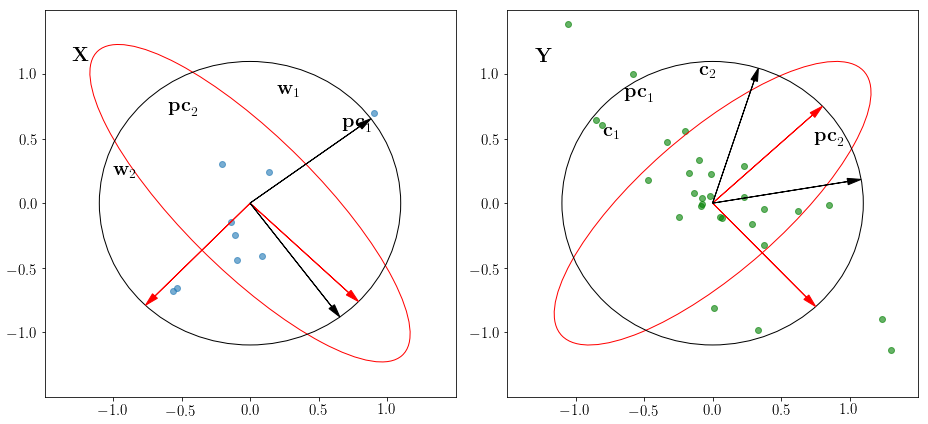

In [211]:
from matplotlib import rc
from matplotlib.patches import Ellipse

r = 2.2
k = 4

x_ellipse = Ellipse([0., 0], height=k * np.sqrt(x_w) , width = k * np.sqrt(x_h), fill=False, angle=y_angle, color='r')
y_ellipse = Ellipse([0., 0], height=k * np.sqrt(y_h) , width = k * np.sqrt(y_w), fill=False, angle=y_angle, color='r')
unit_ball1 = Ellipse([0., 0.], height=r, width=r, fill=False, color='k')
unit_ball2 = Ellipse([0., 0.], height=r, width=r, fill=False, color='k')



rc('text', usetex=True)
plt.figure(figsize=(13, 6))
ax = plt.subplot(1, 2, 1)
plt.scatter(X[40:70, 0], X[40:70, 1], alpha=0.6)
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])
plt.text(.2, .82, '$\mathbf{w}_1$', fontsize=20)
plt.text(.67, .55, '$\mathbf{pc}_1$', fontsize=20)
plt.text(-1., .2, '$\mathbf{w}_2$', fontsize=20)
plt.text(-.6, .68, '$\mathbf{pc}_2$', fontsize=20)
ax.add_artist(x_ellipse)
ax.add_artist(unit_ball1)
ax.arrow(0., 0., -x_comps[0][0], -x_comps[0][1], linewidth=1, head_width=0.05, head_length=0.1, color='r')
ax.arrow(0., 0., x_comps[1][0], x_comps[1][1], linewidth=1, head_width=0.05, head_length=0.1, color='r')
ax.arrow(0., 0., W[0][0], W[0][1], linewidth=1, head_width=0.05, head_length=0.1, color='k')
ax.arrow(0., 0., -W[1][0], -W[1][1], linewidth=1, head_width=0.05, head_length=0.1, color='k')
plt.xticks([-1., -0.5, 0., 0.5, 1.], fontsize=15)
plt.yticks([-1., -0.5, 0., 0.5, 1.], fontsize=15)
plt.text(-1.3, 1.1, '$\mathbf{X}$', fontsize=20)


ax = plt.subplot(1, 2, 2)
plt.scatter(Y[:30, 0], Y[:30, 1], alpha=0.6, c='g')
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])
plt.text(-0.1, .98, '$\mathbf{c}_2$', fontsize=20)
plt.text(.74, .45, '$\mathbf{pc}_2$', fontsize=20)
plt.text(-.8, .5, '$\mathbf{c}_1$', fontsize=20)
plt.text(-.65, .78, '$\mathbf{pc}_1$', fontsize=20)
ax.add_artist(y_ellipse)
ax.add_artist(unit_ball2)
ax.arrow(0., 0., -y_comps[0][0], -y_comps[0][1], linewidth=1, head_width=0.05, head_length=0.1, color='r')
ax.arrow(0., 0., y_comps[1][0], y_comps[1][1], linewidth=1, head_width=0.05, head_length=0.1, color='r')
ax.arrow(0., 0., -C[0][0], -C[0][1], linewidth=1, head_width=0.05, head_length=0.1, color='k')
ax.arrow(0., 0., C[1][0], C[1][1], linewidth=1, head_width=0.05, head_length=0.1, color='k')
plt.xticks([-1., -0.5, 0., 0.5, 1.], fontsize=15)
plt.yticks([-1., -0.5, 0., 0.5, 1.], fontsize=15)
plt.text(-1.3, 1.1, '$\mathbf{Y}$', fontsize=20)

plt.subplots_adjust()
plt.tight_layout()
plt.savefig('figs/PLSFigure.pdf', format="pdf")
plt.show()

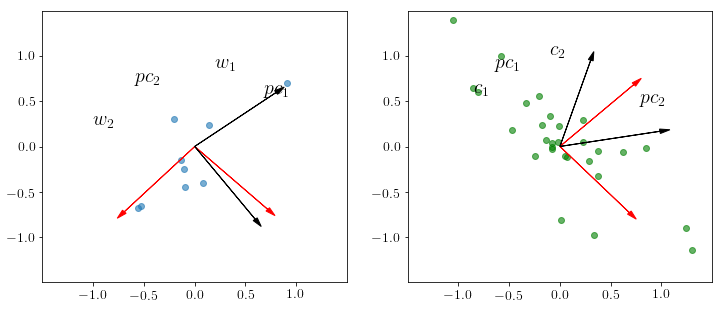

In [212]:
from matplotlib import rc
rc('text', usetex=True)
plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
plt.scatter(X[40:70, 0], X[40:70, 1], alpha=0.6)
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])
plt.text(.2, .82, '$w_1$', fontsize=20)
plt.text(.67, .55, '$pc_1$', fontsize=20)
plt.text(-1., .2, '$w_2$', fontsize=20)
plt.text(-.6, .68, '$pc_2$', fontsize=20)
ax.arrow(0., 0., -x_comps[0][0], -x_comps[0][1], linewidth=1, head_width=0.05, head_length=0.1, color='r')
ax.arrow(0., 0., x_comps[1][0], x_comps[1][1], linewidth=1, head_width=0.05, head_length=0.1, color='r')
ax.arrow(0., 0., W[0][0], W[0][1], linewidth=1, head_width=0.05, head_length=0.1, color='k')
ax.arrow(0., 0., -W[1][0], -W[1][1], linewidth=1, head_width=0.05, head_length=0.1, color='k')
plt.xticks([-1., -0.5, 0., 0.5, 1.], fontsize=14)
plt.yticks([-1., -0.5, 0., 0.5, 1.], fontsize=14)



ax = plt.subplot(1, 2, 2)
plt.scatter(Y[:30, 0], Y[:30, 1], alpha=0.6, c='g')
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])
plt.text(-0.1, .98, '$c_2$', fontsize=20)
plt.text(.78, .45, '$pc_2$', fontsize=20)
plt.text(-.85, .55, '$c_1$', fontsize=20)
plt.text(-.65, .83, '$pc_1$', fontsize=20)
ax.arrow(0., 0., -y_comps[0][0], -y_comps[0][1], linewidth=1, head_width=0.05, head_length=0.1, color='r')
ax.arrow(0., 0., y_comps[1][0], y_comps[1][1], linewidth=1, head_width=0.05, head_length=0.1, color='r')
ax.arrow(0., 0., -C[0][0], -C[0][1], linewidth=1, head_width=0.05, head_length=0.1, color='k')
ax.arrow(0., 0., C[1][0], C[1][1], linewidth=1, head_width=0.05, head_length=0.1, color='k')
plt.xticks([-1., -0.5, 0., 0.5, 1.], fontsize=14)
plt.yticks([-1., -0.5, 0., 0.5, 1.], fontsize=14)

plt.show()

In [213]:
W[0].dot(W[1])

-2.7755575615628914e-16